In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import shap

/Users/rohitkulkarni/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#  Load Data

patients = pd.read_csv("patients.csv")
admissions = pd.read_csv("admissions.csv", parse_dates=["admittime", "dischtime"])
diagnoses = pd.read_csv("diagnoses_icd.csv")
d_icd_diag = pd.read_csv("d_icd_diagnoses.csv")
procedures = pd.read_csv("procedures_icd.csv", parse_dates=["chartdate"])
d_icd_proc = pd.read_csv("d_icd_procedures.csv")
transfers = pd.read_csv("transfers.csv", parse_dates=["intime", "outtime"])

In [3]:
# Merge and Clean

admissions = admissions.merge(patients[['subject_id', 'gender']], on='subject_id', how='left')
if 'anchor_age' in patients.columns:
    admissions = admissions.merge(patients[['subject_id', 'anchor_age']], on='subject_id', how='left')
    admissions.rename(columns={"anchor_age": "age"}, inplace=True)

# Sort by time for readmission logic
admissions = admissions.sort_values(by=['subject_id', 'admittime'])
admissions['next_admit'] = admissions.groupby('subject_id')['admittime'].shift(-1)
admissions['days_to_next_admit'] = (admissions['next_admit'] - admissions['dischtime']).dt.days
admissions['readmit_30'] = ((admissions['days_to_next_admit'] >= 0) &
                            (admissions['days_to_next_admit'] <= 30)).astype(int)

In [4]:
# Feature Engineering

# Length of stay
admissions['los'] = (admissions['dischtime'] - admissions['admittime']).dt.days

# Age group
admissions['age_group'] = pd.cut(admissions['age'], bins=[0,30,50,70,90,150], labels=False)

# Number of diagnoses and procedures
admissions['n_diagnoses'] = admissions['hadm_id'].map(diagnoses.groupby('hadm_id').size())
admissions['n_procedures'] = admissions['hadm_id'].map(procedures.groupby('hadm_id').size())
admissions['n_diagnoses'].fillna(0, inplace=True)
admissions['n_procedures'].fillna(0, inplace=True)

# ICU flag
icu_flag = transfers[transfers['careunit'].str.contains("ICU", na=False)]
icu_flag = icu_flag.groupby('hadm_id').size().reset_index(name='icu_flag')
icu_flag['icu_flag'] = 1
admissions = admissions.merge(icu_flag[['hadm_id', 'icu_flag']], on='hadm_id', how='left')
admissions['icu_flag'] = admissions['icu_flag'].fillna(0)

# One-hot encoding
admissions = pd.get_dummies(admissions, columns=['admission_type', 'insurance', 'gender'], drop_first=True)

# Previous admissions
admissions['num_prev_admissions'] = admissions.groupby('subject_id').cumcount()

# Days since last discharge
admissions['prev_discharge'] = admissions.groupby('subject_id')['dischtime'].shift(1)
admissions['days_since_last_discharge'] = (admissions['admittime'] - admissions['prev_discharge']).dt.days
admissions['days_since_last_discharge'].fillna(-1, inplace=True)

# Discharged home
admissions['discharged_home'] = admissions['discharge_location'].fillna('').str.contains('HOME|SELF', case=False).astype(int)

# Emergency admit flag
admissions['emergency_admit_flag'] = admissions['admission_location'].fillna('').str.contains('EMER', case=False).astype(int)

# High procedure count
admissions['has_multiple_procedures'] = (admissions['n_procedures'] > 1).astype(int)
threshold = admissions['n_procedures'].quantile(0.90)
admissions['high_procedure_burden'] = (admissions['n_procedures'] >= threshold).astype(int)


/var/folders/zr/3d272zpd4vv3hvlhrp34nnyr0000gn/T/ipykernel_7740/1133882249.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  admissions['n_diagnoses'].fillna(0, inplace=True)
/var/folders/zr/3d272zpd4vv3hvlhrp34nnyr0000gn/T/ipykernel_7740/1133882249.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [5]:
# Feature Selection

base_features = ['age', 'los', 'n_diagnoses', 'n_procedures', 'icu_flag']
categorical_features = [col for col in admissions.columns if col.startswith(('admission_type_', 'insurance_', 'gender_'))]
synthetic_features = [
    'num_prev_admissions', 'days_since_last_discharge',
    'discharged_home', 'emergency_admit_flag',
    'has_multiple_procedures', 'high_procedure_burden'
]

selected_features = base_features + categorical_features + synthetic_features

admissions_model = admissions.copy()

# Fill numeric features with 0 or -1 depending on meaning
fill_zero = ['n_diagnoses', 'n_procedures', 'num_prev_admissions', 'icu_flag', 'has_multiple_procedures']
fill_neg1 = ['days_since_last_discharge']

for col in fill_zero:
    admissions_model[col] = admissions_model[col].fillna(0)

for col in fill_neg1:
    admissions_model[col] = admissions_model[col].fillna(-1)

# For synthetic binary flags — fill with 0 (absence)
binary_flags = ['discharged_home', 'emergency_admit_flag', 'high_procedure_burden']
for col in binary_flags:
    admissions_model[col] = admissions_model[col].fillna(0)

# If any one-hot encoded columns have NaN (unlikely), fill with 0
one_hot_cols = [col for col in admissions_model.columns if col.startswith(('admission_type_', 'insurance_', 'gender_'))]
for col in one_hot_cols:
    admissions_model[col] = admissions_model[col].fillna(0)

# Final feature + label prep
X = admissions_model[selected_features]
y = admissions_model['readmit_30']

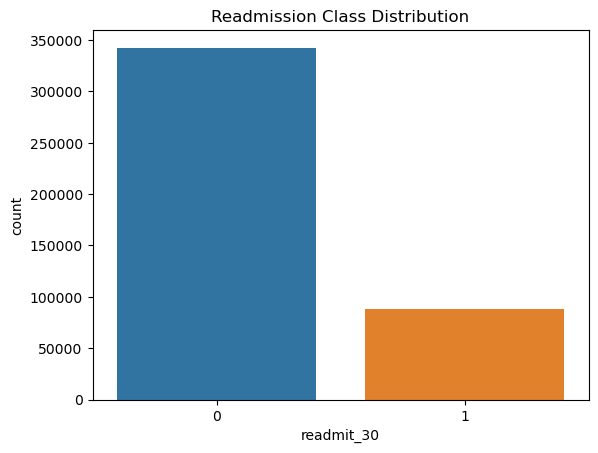

readmit_30
0    0.794752
1    0.205248
Name: proportion, dtype: float64


In [6]:
# Distribution of Readmission

sns.countplot(data=admissions, x='readmit_30')
plt.title("Readmission Class Distribution")
plt.show()

print(admissions['readmit_30'].value_counts(normalize=True))

/Users/rohitkulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rohitkulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rohitkulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rohitkulkarni/anaconda3/lib/python3.11/site-packag

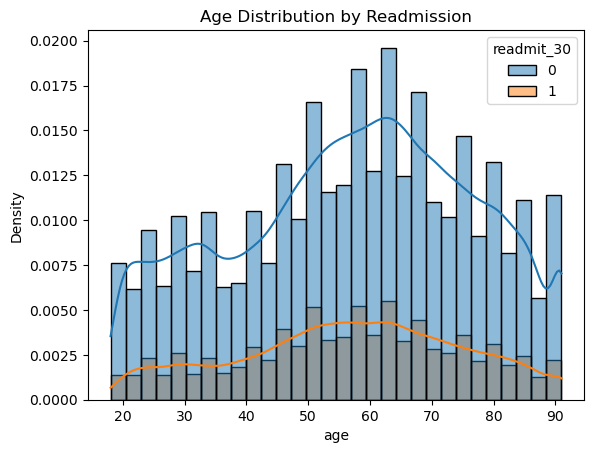

In [7]:
# Age vs Readmission

sns.histplot(data=admissions, x='age', hue='readmit_30', bins=30, kde=True, stat='density')
plt.title("Age Distribution by Readmission")
plt.show()

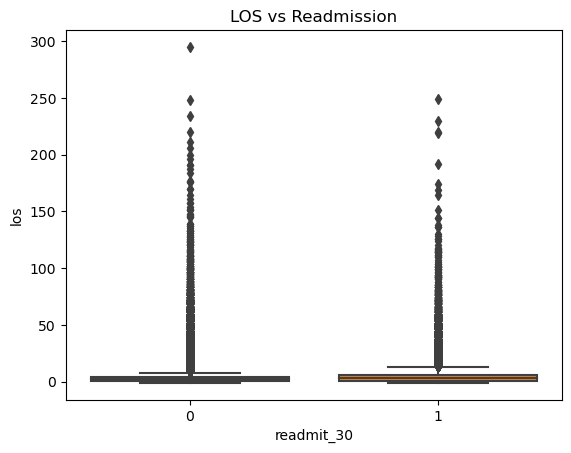

In [8]:
# Length of Stay vs Readmission

sns.boxplot(data=admissions, x='readmit_30', y='los')
plt.title("LOS vs Readmission")
plt.show()

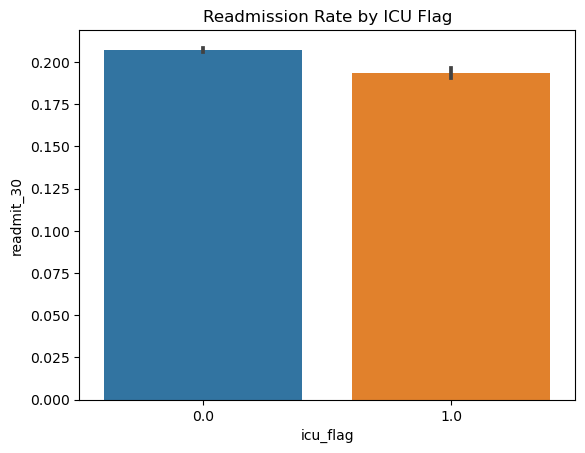

In [9]:
# ICU Flag vs Readmission

sns.barplot(data=admissions, x='icu_flag', y='readmit_30')
plt.title("Readmission Rate by ICU Flag")
plt.show()

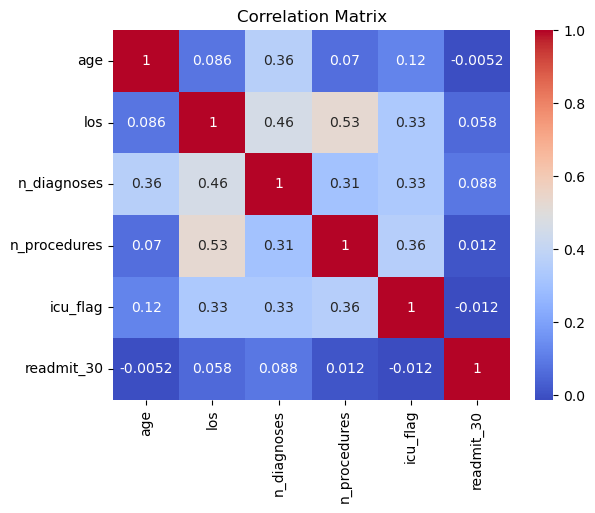

In [10]:
# Correlation Heatmap

num_cols = ['age', 'los', 'n_diagnoses', 'n_procedures', 'icu_flag', 'readmit_30']
sns.heatmap(admissions[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Model Performance:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77     68522
           1       0.33      0.59      0.43     17696

    accuracy                           0.68     86218
   macro avg       0.60      0.64      0.60     86218
weighted avg       0.76      0.68      0.70     86218

ROC AUC Score: 0.6984079683123906


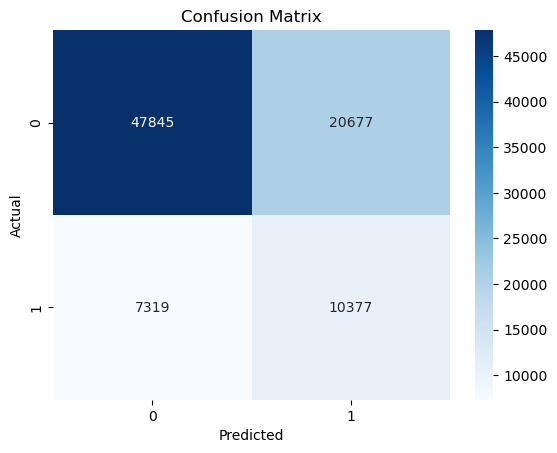

In [11]:
# Model Training

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation

print("Model Performance:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:
import joblib
import os

# Create model folder
os.makedirs("models", exist_ok=True)

joblib.dump(model, "models/rf_readmit_model.pkl")
joblib.dump(X.columns.tolist(), "models/readmit_model_features.pkl")

['models/readmit_model_features.pkl']

In [ ]:
# predict_readmit.py

import pandas as pd
import joblib
import os

# Load model and features on module load
MODEL_PATH = os.path.join("models", "xgb_readmit_model.pkl")
FEATURES_PATH = os.path.join("models", "readmit_model_features.pkl")

model = joblib.load(MODEL_PATH)
feature_list = joblib.load(FEATURES_PATH)


def predict_readmission(input_data: dict) -> dict:
    """
    Predict readmission risk from a single patient input dictionary.

    Args:
        input_data (dict): A dictionary of patient input features

    Returns:
        dict: {
            'readmit_prob': float (0–1),
            'readmit_pred': 0 or 1,
            'risk_tier': "Low" / "Medium" / "High"
        }
    """
    # Build dataframe with one row
    df = pd.DataFrame([input_data])

    missing_cols = set(feature_list) - set(df.columns)
    for col in missing_cols:
        df[col] = 0

    # Reorder
    df = df[feature_list]

    # Predict
    prob = model.predict_proba(df)[0][1]
    pred = model.predict(df)[0]

    # Risk Tier
    if prob >= 0.75:
        tier = "High"
    elif prob >= 0.50:
        tier = "Medium"
    else:
        tier = "Low"

    return {
        "readmit_prob": round(prob, 4),
        "readmit_pred": int(pred),
        "risk_tier": tier
    }